# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

PATH_FIGS = os.path.join(REPOSITORY_PATH,'figs','EvalDeepEnsemble')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data

In [5]:
import uncertainty.metrics as metrics
from uncertainty.ensemble import DeepEnsemble

# Analysis

## Definitions

In [6]:
MODEL_ARC = 'ResNet50'
DATA = 'Cifar100'

data = torch_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

Files already downloaded and verified
Files already downloaded and verified


## Upload Models

In [7]:
def weights_files(weights_path):
    #Get all weight files in weights_path
    files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
    files = sorted(files)
    return files


In [8]:
models_dict = {}
for s in weights_files(weights_path):
    print(s)
    s1 = s.replace('.pt','')
    models_dict[s1] = model_class(num_classes = data.n_classes,softmax = True).to(dev)
    state_dict = torch.load(os.path.join(weights_path,s))
    models_dict[s1].load_state_dict(state_dict)
    models_dict[s1].eval()
    print(f'model acc = {TE.model_acc( models_dict[s1],data.test_dataloader)}')

ResNet50_Cifar1000no_conv_drop_checkpoint.pt
model acc = 78.44
ResNet50_Cifar1001no_conv_drop_checkpoint.pt
model acc = 79.31
ResNet50_Cifar1002no_conv_drop_checkpoint.pt
model acc = 77.96
ResNet50_Cifar1003no_conv_drop_checkpoint.pt
model acc = 78.8
ResNet50_Cifar100_checkpoint.pt
model acc = 75.2


### Ensemble model definition

In [9]:
model = DeepEnsemble(models_dict).to(dev)
print(f'Ensemble Total Accuracy: {TE.model_acc(model,data.test_dataloader)}')

Ensemble Total Accuracy: 81.25


## Plots

### Por M

In [13]:
RC_dict = {}
for N_ENS in range(1,len(models_dict)+1):
    NAME = f'DeepEnsemble_{N_ENS}_{MODEL_ARC}_{DATA}'
    d = utils.slice_dict(models_dict,range(N_ENS))
    model = DeepEnsemble(d).to(dev)
    RC = metrics.selective_metrics(model,data.test_dataloader, name = NAME)
    RC_dict[N_ENS] = RC

#### Risk x Coverage

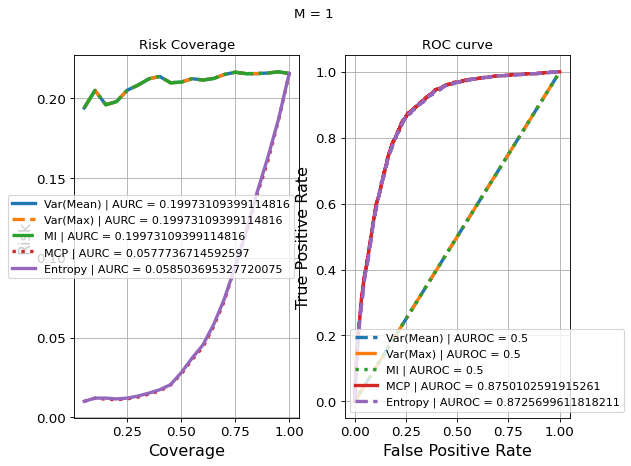

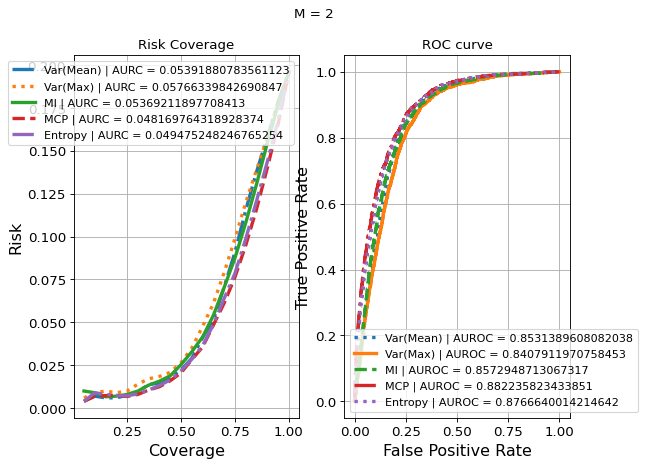

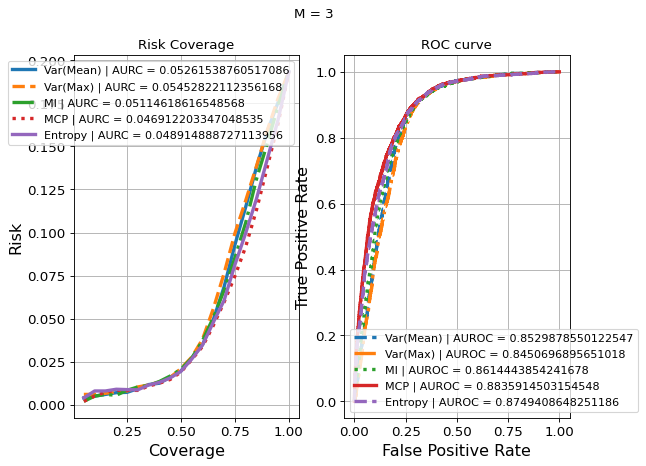

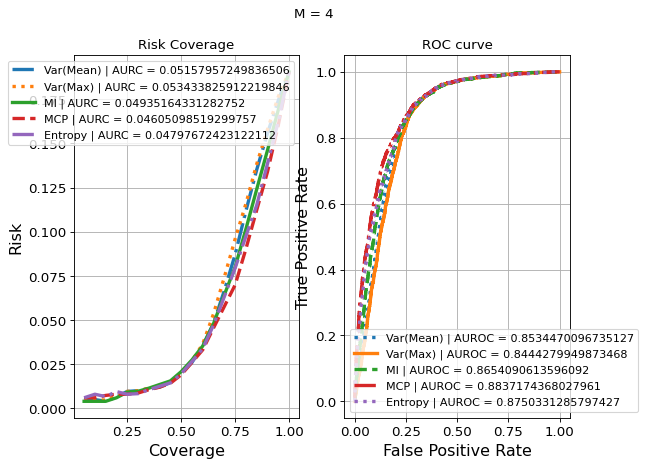

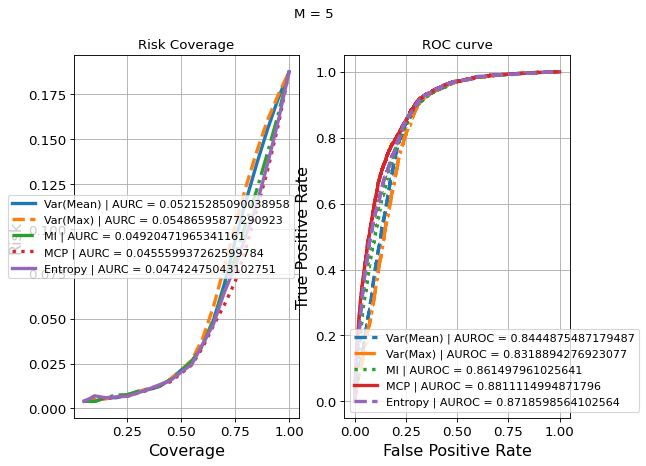

In [14]:
for N_ENS, RC in RC_dict.items():
    NAME = f'DeepEnsemble_{N_ENS}_{MODEL_ARC}_{DATA}'
    RC.plot_ROC_and_RC(aurc = True)
    plt.suptitle(f'M = {N_ENS}')
    plt.show()

#### Risk x M

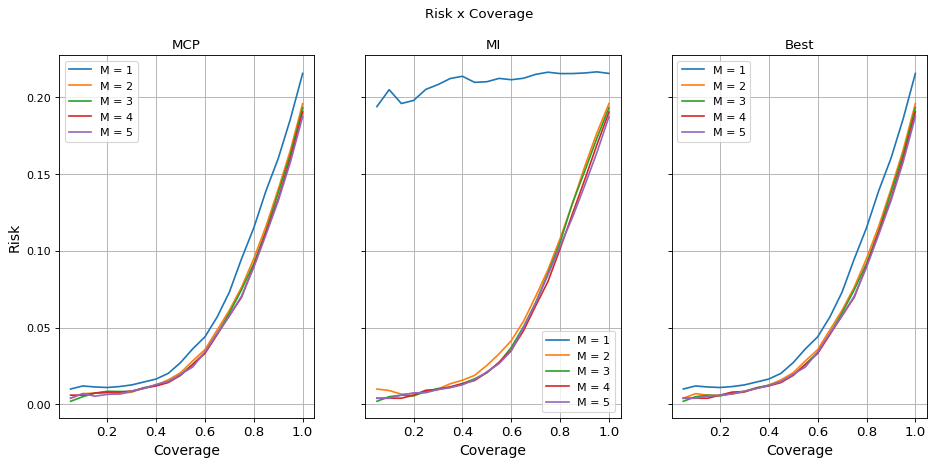

In [15]:
uncs = ['MCP','MI','Best']
#RC.set_uncs(uncs)
f, axes = plt.subplots(1, len(uncs),sharey = True,figsize=(14,6),dpi=80)
for N_ENS, RC in RC_dict.items():
    
    for i,unc in enumerate(uncs):
        if unc in RC.risk.keys():
            axes[i].plot(RC.c_list,RC.risk[unc],label = f'M = {N_ENS}')
        elif unc == 'Best':
            axes[i].plot(RC.c_list,RC.get_best(),label = f'M = {N_ENS}')
        else:
            continue
    NAME = f'DeepEnsemble_{N_ENS}_{MODEL_ARC}_{DATA}'
    
for i,unc in enumerate(uncs):
    axes[i].set_title(uncs[i])
    axes[i].set_xlabel("Coverage", fontsize=RC.LABEL_FONTSIZE*0.7)
    axes[i].tick_params(axis="x",labelsize=RC.TICKS_FONTSIZE)
    axes[i].grid()
    axes[i].legend()
axes[0].set_ylabel("Risk", fontsize=RC.LABEL_FONTSIZE*0.7)
plt.suptitle(f'Risk x Coverage')
plt.show()